# Disclamier

* https://www.youtube.com/watch?v=vV12dGe_Fho&ab_channel=RobMulla
* https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467


In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost

plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

# Types of Time-Series

<img src ='types_of_time_series.jpg' width='500' />

In [157]:
import os
print(os.getcwd())

/Users/kevintsai/Library/CloudStorage/Dropbox/Study/Python/Machine Learning/Time-Series/Energy Consumption


In [158]:
df = pd.read_csv('AEP_hourly.csv')


In [159]:
df.head(5)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [161]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

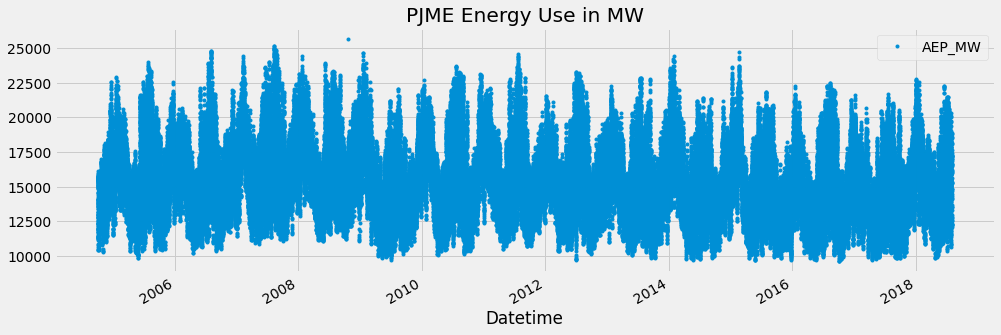

In [163]:
df.plot(style='.',
        figsize=(15,5),
        title='PJME Energy Use in MW',
        grid=True
        )

seems like a seasonal trends

## Train / Test Split

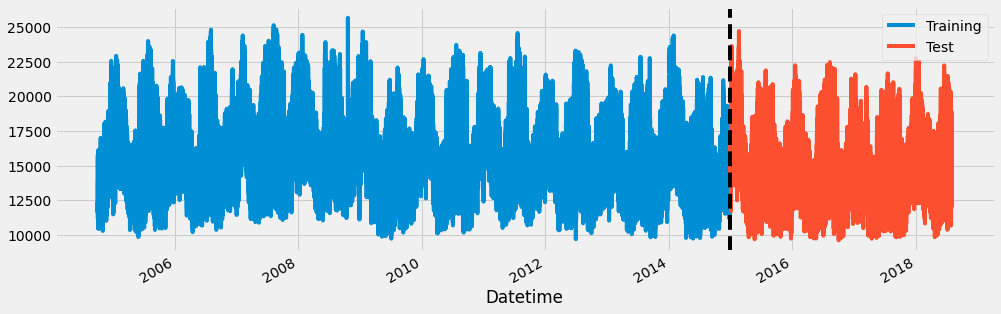

In [164]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

#explicitly create fig/ax
fig, ax = plt.subplots(figsize=(15,5)) 

train.plot(ax=ax, label ='Training')
test.plot(ax=ax, label = 'Test')

#add vertical line
ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training', 'Test'])

plt.show()

<Axes: title={'center': 'Week Consumption'}, xlabel='Datetime'>

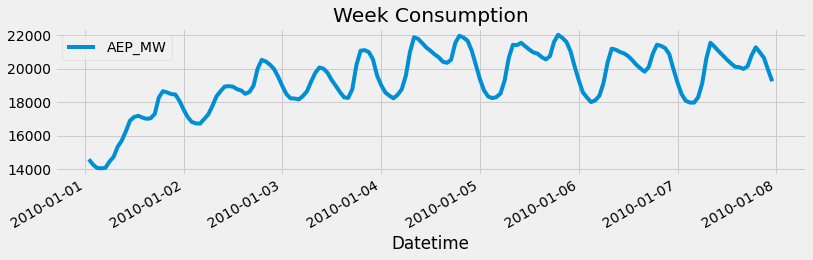

In [165]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]\
    .plot(figsize=(12,3),
          title = 'Week Consumption'
          )


### Feature Creation

In [166]:
df.index.hour

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
       15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
      dtype='int32', name='Datetime', length=121273)

In [167]:
def create_feature(df):
    """
    Create time series feature based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    return df
df = create_feature(df)

# Visualize feature/target Relationship

Text(0.5, 1.0, 'MW by hour')

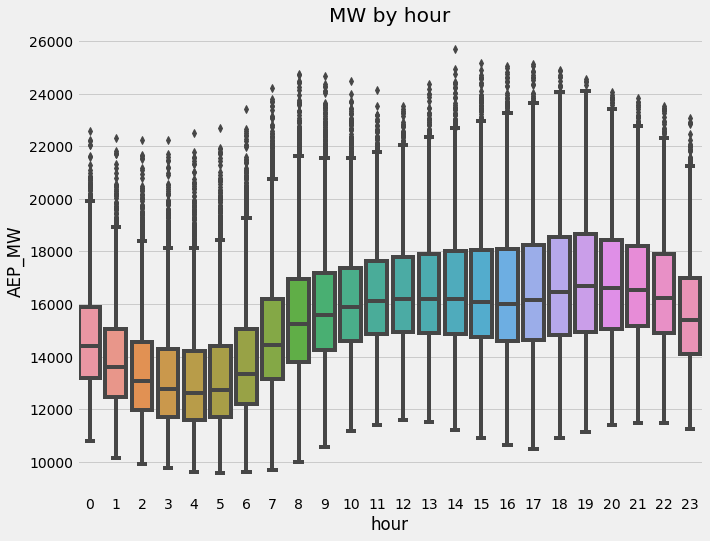

In [168]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,
            x='hour', 
            y='AEP_MW',
            )

ax.set_title('MW by hour')

Power consumper is higher during the day, and peaked between 18 and 20 hour

Text(0.5, 1.0, 'MW by month')

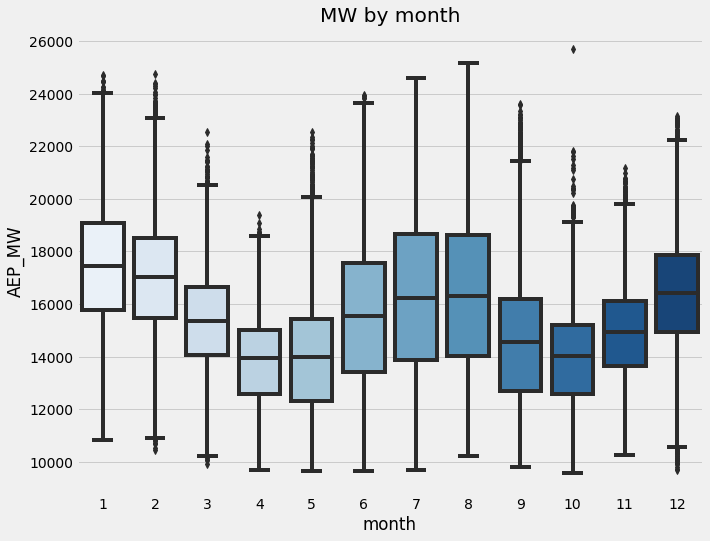

In [169]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,
            x='month', 
            y='AEP_MW',
            palette='Blues'
            )

ax.set_title('MW by month')

MW by month, peak between june/agus (Summer), also dec/feb (Winter)

## Create Moodel

In [170]:
# Define metrics
from sklearn.metrics import mean_squared_error


train = create_feature(train)
test = create_feature(test)



In [171]:
FEATURES = ['hour', 'week', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [172]:
# fit model

reg = xgboost.XGBRegressor(n_estimators=1000,
                           learning_rate = 0.01
                           )
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose = 50 # or verbose = True
        )

[0]	validation_0-rmse:15792.50936	validation_1-rmse:14861.30366
[50]	validation_0-rmse:9634.50001	validation_1-rmse:8730.41280
[100]	validation_0-rmse:5946.76890	validation_1-rmse:5177.35119
[150]	validation_0-rmse:3766.04868	validation_1-rmse:3161.23788
[200]	validation_0-rmse:2508.95368	validation_1-rmse:2124.36626
[250]	validation_0-rmse:1825.08057	validation_1-rmse:1697.82594
[300]	validation_0-rmse:1472.70614	validation_1-rmse:1577.19471
[350]	validation_0-rmse:1292.36652	validation_1-rmse:1566.09294
[400]	validation_0-rmse:1198.79691	validation_1-rmse:1584.94295
[450]	validation_0-rmse:1145.77002	validation_1-rmse:1602.47676
[500]	validation_0-rmse:1110.33811	validation_1-rmse:1620.18343
[550]	validation_0-rmse:1084.10345	validation_1-rmse:1638.61733
[600]	validation_0-rmse:1065.04359	validation_1-rmse:1653.13583
[650]	validation_0-rmse:1052.51495	validation_1-rmse:1663.48198
[700]	validation_0-rmse:1042.60485	validation_1-rmse:1674.68719
[750]	validation_0-rmse:1029.04707	valida

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [173]:
result = reg.evals_result()



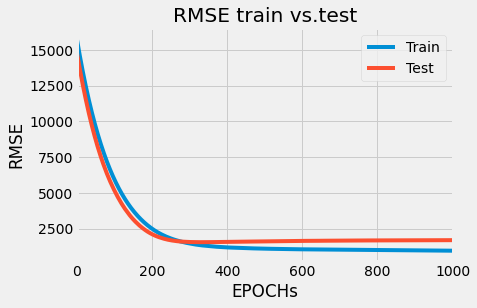

In [174]:
train_rmse = result['validation_0']['rmse']
test_rmse = result['validation_1']['rmse']
epochs = range(0, len(result['validation_1']['rmse']))
fig, ax = plt.subplots()

ax.plot(epochs, train_rmse)
ax.plot(epochs, test_rmse)
ax.set_xlabel('EPOCHs')
ax.set_ylabel('RMSE')
ax.set_title('RMSE train vs.test')

ax.set_xlim(left=0, right=1000)
ax.legend(['Train', 'Test'])


* should set the early stop at around 250

In [190]:
# fit model

reg = xgboost.XGBRegressor(n_estimators=1000, 
                           early_stopping_rounds = 10,
                           learning_rate = 0.01,
                           #epochs = 250
                           )

reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose = 50 # or verbose = True
        )

[0]	validation_0-rmse:15792.50936	validation_1-rmse:14861.30366
[50]	validation_0-rmse:9634.50001	validation_1-rmse:8730.41280
[100]	validation_0-rmse:5946.76890	validation_1-rmse:5177.35119
[150]	validation_0-rmse:3766.04868	validation_1-rmse:3161.23788
[200]	validation_0-rmse:2508.95368	validation_1-rmse:2124.36626
[250]	validation_0-rmse:1825.08057	validation_1-rmse:1697.82594
[300]	validation_0-rmse:1472.70614	validation_1-rmse:1577.19471
[342]	validation_0-rmse:1313.79039	validation_1-rmse:1564.68538


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature Importance'}>

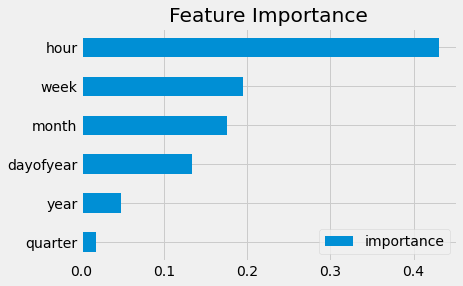

In [191]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns = ['importance']
                  )

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

### Forecast on Test

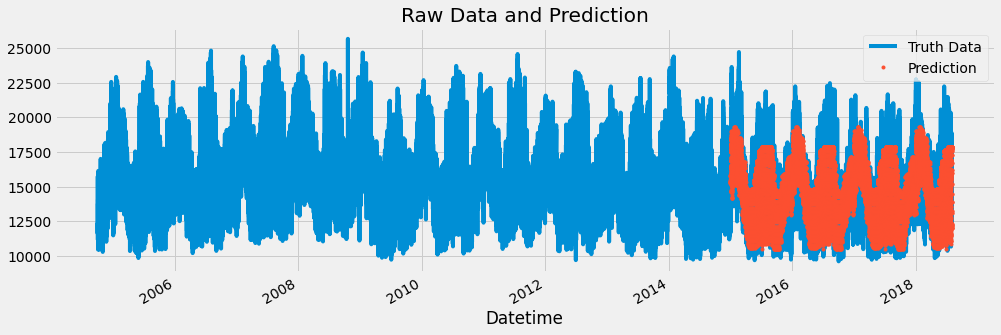

In [192]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test['prediction'], how='left', left_index = True, right_index=True)

ax = df['AEP_MW'].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')

plt.legend(['Truth Data','Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()

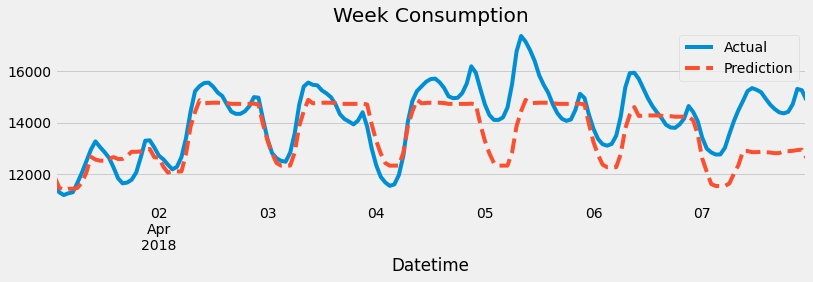

In [203]:
ax = df['AEP_MW'].loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]\
    .plot(figsize=(12,3),
          title = 'Week Consumption'
          )
df['prediction'].loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]\
    .plot(figsize=(12,3),
          linestyle = '--'
          )

ax.legend(['Actual', 'Prediction'])


In [206]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))

print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1563.38


* next step :Try hyperparameter tunning or feature creation to boost the prediction

Features: moving averages, holidays etc

In [208]:
df['AEP_MW_5days_avg'] = df['AEP_MW'].rolling(5).mean()
df['AEP_MW_10days_avg'] = df['AEP_MW'].rolling(10).mean()
df['AEP_MW_15days_avg'] = df['AEP_MW'].rolling(15).mean()
df['AEP_MW_30days_avg'] = df['AEP_MW'].rolling(30).mean()

In [212]:
FEATURES = ['hour', 'week', 'quarter', 'month', 'year', 'dayofyear', 'AEP_MW_5days_avg', 'AEP_MW_10days_avg', 'AEP_MW_15days_avg', 'AEP_MW_30days_avg']
TARGET = 'AEP_MW'


train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']


X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# fit model

reg = xgboost.XGBRegressor(n_estimators=1000, 
                           early_stopping_rounds = 10,
                           learning_rate = 0.01,
                           )

reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose = 50 # or verbose = True
        )



[0]	validation_0-rmse:15791.25986	validation_1-rmse:14846.76042
[50]	validation_0-rmse:9568.99010	validation_1-rmse:8968.69144
[100]	validation_0-rmse:5807.16211	validation_1-rmse:5418.75903
[150]	validation_0-rmse:3536.17762	validation_1-rmse:3279.90840
[200]	validation_0-rmse:2170.48678	validation_1-rmse:1996.36546
[250]	validation_0-rmse:1355.10875	validation_1-rmse:1234.02431
[300]	validation_0-rmse:874.83018	validation_1-rmse:795.06970
[350]	validation_0-rmse:599.42479	validation_1-rmse:555.04701
[400]	validation_0-rmse:448.24777	validation_1-rmse:435.15535
[450]	validation_0-rmse:369.35076	validation_1-rmse:378.67844
[500]	validation_0-rmse:327.62216	validation_1-rmse:352.06227
[550]	validation_0-rmse:304.17163	validation_1-rmse:337.42259
[600]	validation_0-rmse:289.99180	validation_1-rmse:328.77387
[650]	validation_0-rmse:279.62804	validation_1-rmse:321.40566
[700]	validation_0-rmse:271.82636	validation_1-rmse:315.72924
[750]	validation_0-rmse:265.19933	validation_1-rmse:308.255

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

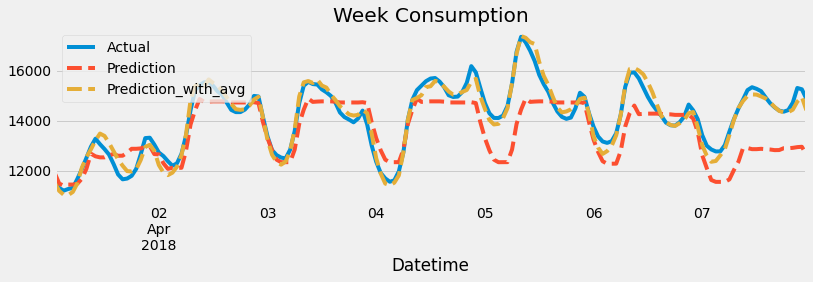

In [224]:
test['prediction_with_avg'] = reg.predict(X_test)
df = df.merge(test['prediction_with_avg'], how='left', left_index = True, right_index=True)


ax = df['AEP_MW'].loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]\
    .plot(figsize=(12,3),
          title = 'Week Consumption'
          )
df['prediction'].loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]\
    .plot(figsize=(12,3),
          linestyle = '--'
          )
df['prediction_with_avg'].loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]\
    .plot(figsize=(12,3),
          linestyle = '--'
          )


ax.legend(['Actual', 'Prediction', 'Prediction_with_avg'])


# Kevin future improvments :
* Prediction with avg fits well. But only works for daily prediction.
* If for annual planning, this method has data leakage problem. 

* Ideas for features inclduing:
    * Last 3 years of calder month average :  (average(1999, 2000, 2001))
    * Growth Rate of last 2 years (Jan-2002 : Jan-2001 / Jan-2000): 
